In [ ]:
!pip install -q keras sklearn tensorflow jupyter 

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import collections

import sklearn
from sklearn import metrics
from sklearn.decomposition import PCA

from tensorflow import keras
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Reshape, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential, load_model
from keras.applications.vgg16 import VGG16
from keras.utils import np_utils

import cv2
import os
import zipfile 
from google.colab import drive


In [ ]:
train_Directory = './drive/MyDrive/TFG/TFG_Compartido/ORL/ORL_Combined/ORL_Combined_Train/'
test_Directory = './drive/MyDrive/TFG/TFG_Compartido/ORL/ORL_Combined/ORL_Combined_Test/'

In [ ]:

ntoTest = ntoTrain = classes = 0

for _, dirnames, filenames in os.walk(train_Directory):
    classes += len(dirnames)
    ntoTrain += len(filenames)
    
for _, dirnames, filenames in os.walk(test_Directory):
    ntoTest += len(filenames)
    

print (str(classes) + " classes found.")
print("Train files: " + str(ntoTrain))
print("Test files: " + str(ntoTest))

40 classes found.
Train files: 549
Test files: 309


In [ ]:
batch_size = 7
n_classes = classes
imgL = 224
imgDims = (imgL, imgL)
input_shape = (imgL,imgL,3)

cnn_model_flag = 1 ## Feature extractor to choose (1 - VGG16, 2 - VGG19, 3 - ResNet50, 4 - ResNet101, 5 - Inception)
classifier_flag = 1 ## Classifier to choose (1 - LinearSVM, 2 - MLP, 3 - RandomForest)

if cnn_model_flag > 5 or cnn_model_flag < 1:
  cnn_model_flag = 1
if classifier_flag > 3 or classifier_flag < 1:
  classifier_flag = 1


In [ ]:
def extract_y(y_dummy):
  label_vector = []
  i = 0
  while (i < len(y_dummy)):
    j = 0
    while (j < len(y_dummy[i])):
      if (y_dummy[i][j]):
        label_vector.append(j)
        break
      j += 1  
    i += 1
  return label_vector



In [ ]:
dataAugmentTrain = 2
dataAugmentTest = 1

IDG_train = ImageDataGenerator(rotation_range = 10,brightness_range= (0.1, 0.2)) ## rescale=1./255
IDG_test = ImageDataGenerator(rotation_range = 10,brightness_range= (0.1, 0.2) ) ## rescale=1./255
train_generator = IDG_train.flow_from_directory(
    directory = train_Directory, class_mode = 'categorical', batch_size = ntoTrain,
    target_size=imgDims, color_mode='rgb', shuffle = True
)

test_generator = IDG_test.flow_from_directory(
    directory = test_Directory, class_mode = 'categorical', batch_size = ntoTest,
    target_size=imgDims, color_mode='rgb', shuffle = True
)
print(len(train_generator.labels))
# Obtenemos los arrays de imagenes-labels

x_train,dummy_vector = train_generator.next()
y_train = extract_y(dummy_vector)
x_test,dummy_vector = test_generator.next()
y_test =  extract_y(dummy_vector)

x = dataAugmentTrain
while x > 0:
  x_train2,dummy_vector = train_generator.next()
  y_train2 = extract_y(dummy_vector)
  x_train = np.append(x_train, x_train2, axis=0)
  y_train = np.append(y_train, y_train2, axis=0)
  x -= 1

x = dataAugmentTest
while x > 0:
  
  x_test2,dummy_vector  = test_generator.next()
  y_test2 =  extract_y(dummy_vector)
  x_test = np.append(x_test, x_test2, axis=0)
  y_test = np.append(y_test, y_test2, axis=0)
  x -= 1

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


Found 549 images belonging to 40 classes.
Found 309 images belonging to 40 classes.
549
(1647, 224, 224, 3)
(618, 224, 224, 3)
(1647,)
(618,)


In [ ]:
# VGG16
def getVGG16Model():
  vgg_model = VGG16(weights='imagenet', input_shape=input_shape, include_top=False)

  # Establecemos las capas interiores como no-entrenables
  for layer in vgg_model.layers[:]:
      layer.trainable = False

  vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  vgg_model.summary()

  return vgg_model

# VGG-19 
def getVGG19Model():
  VGG19model = keras.applications.VGG19(weights='imagenet', input_shape=input_shape, include_top=False)

  # Establecemos las capas interiores como no-entrenables
  for layer in VGG19model.layers[:]:
    layer.trainable = False

  VGG19model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  VGG19model.summary()

  return VGG19model

# RESNET50
def getRESNET50Model():
  rn50model = keras.applications.ResNet50V2(weights='imagenet', input_shape=input_shape, include_top=False)

  # Establecemos las capas interiores como no-entrenables
  for layer in rn50model.layers[:]:
    layer.trainable = False

  rn50model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  rn50model.summary()

  return rn50model

# RESNET101v2
def getRESNET101Model():
  rn101model = keras.applications.ResNet101V2(weights='imagenet', input_shape=input_shape, include_top=False)

  # Establecemos las capas interiores como no-entrenables
  for layer in rn101model.layers[:]:
    layer.trainable = False

  rn101model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  rn101model.summary()

  return rn101model

# Inception
def getInceptionModel():
  inceptionModel = keras.applications.InceptionV3(weights='imagenet', input_shape=input_shape, include_top=False)

  # Establecemos las capas interiores como no-entrenables
  for layer in inceptionModel.layers[:]:
    layer.trainable = False

  inceptionModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  inceptionModel.summary()

  return inceptionModel

if cnn_model_flag == 1:
  cnnModel = getVGG16Model()
if cnn_model_flag == 2:
  cnnModel = getVGG19Model()
if cnn_model_flag == 3:
  cnnModel = getRESNET50Model()
if cnn_model_flag == 4:
  cnnModel = getRESNET101Model()
if cnn_model_flag == 5:
  cnnModel = getInceptionModel()


58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:
x_train_fExtracted = cnnModel.predict(x_train )
x_test_fExtracted = cnnModel.predict(x_test)

In [ ]:
## PCA Dimensionality reduction 
pca_components = 384 # cnn output to 384 features
X_train_PCA = x_train_fExtracted.reshape(x_train_fExtracted.shape[0], -1)
pca = PCA(n_components = pca_components, whiten = True).fit(X_train_PCA)
X_for_ML  = pca.transform(X_train_PCA)

x_test_for_ML = pca.transform(x_test_fExtracted.reshape(x_test_fExtracted.shape[0], -1))


In [ ]:

if classifier_flag == 1: 

  from sklearn import svm

  clf = svm.LinearSVC()
  clf.fit(X_for_ML, y_train)
if classifier_flag == 2: 

  from sklearn.neural_network import MLPClassifier
  print("Fitting the classifier to the training set")
  x = 0
  lacc = 0 
  #dummy classifier
  savedClass = MLPClassifier(hidden_layer_sizes=(1024,), batch_size = 28, early_stopping = True, n_iter_no_change=25 )
  niter = 10
  nbatch = 48
  while x <= 10 and lacc < 0.97:
    
    classifier = MLPClassifier(hidden_layer_sizes=(1536,768,), batch_size = nbatch, early_stopping = True, n_iter_no_change=niter ).fit(X_for_ML, y_train)
    
    y_pred = classifier.predict(x_test_for_ML)
    acc = sklearn.metrics.precision_score(y_true = y_test,y_pred = y_pred, average='macro', zero_division=0)
    print("Acc for "+ str(x) + " · "+ str(acc))

    if acc > lacc:
      print("At "+ str(x) +" precision: "+ str(acc)+ "\tBetter than "+str(lacc) )
      savedClass = classifier
      lacc = acc
    else:
      niter += 1
    x += 1 

  clf = savedClass
if classifier_flag == 3: 
  
  from sklearn.ensemble import RandomForestClassifier as RFC 

  clf = RFC(n_estimators = 512, random_state = 42)
  clf.fit(X_for_ML, y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
pred_clf = clf.predict(x_test_for_ML)

In [ ]:
print ("Accuracy = ", metrics.accuracy_score(y_test, pred_clf))
print ("Classification Report:\n")
print (metrics.classification_report( y_test, pred_clf,zero_division = 0 ))

Accuracy =  0.941747572815534
Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       1.00      1.00      1.00        16
           2       1.00      0.81      0.90        16
           3       1.00      0.81      0.90        16
           4       1.00      0.88      0.93        16
           5       1.00      1.00      1.00        16
           6       0.84      1.00      0.91        16
           7       1.00      1.00      1.00        16
           8       0.94      1.00      0.97        16
           9       1.00      1.00      1.00        14
          10       1.00      1.00      1.00        16
          11       0.94      1.00      0.97        16
          12       1.00      0.75      0.86        16
          13       1.00      1.00      1.00        16
          14       1.00      1.00      1.00        16
          15       1.00      0.75      0.86        16
          16       0.94    

In [ ]:
# cm = metrics.multilabel_confusion_matrix( y_test, pred_clf )
# print( "Confusion matrix for each class")
# i = 0
# for cm_row in cm :
#   print("CM " + str(i))
#   print (cm_row)
#   i = i+1


labels = []
i = 0
while i < n_classes:
  labels.append(i)
  i += 1

Confusion_Matrix = np.zeros((n_classes, n_classes))


i = 0
while i < len(pred_clf):
  Confusion_Matrix[y_test[i]][pred_clf[i]] += 1
  i += 1


matrix_str = "Pred:\t"

i = 0
while i < len(labels):
  matrix_str += str(labels[i])+"\t"
  i += 1


matrix_str += "\nReal\n"
i = 0
while (i < len(Confusion_Matrix)):
  j = 0
  matrix_str += str(i)+"\t"
  while j < len(Confusion_Matrix[i]) : 
    matrix_str += str(Confusion_Matrix[i][j])+"\t"
    j += 1
  i+= 1
  matrix_str += "\n"
  
print (matrix_str)



Pred:	0	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	29	30	31	32	33	34	35	36	37	38	39	
Real
0	13.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	
1	0.0	16.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	
2	0.0	0.0	13.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	2.0	
3	0.0	0.0	0.0	13.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	3.0	0.0	0.0	0.0	0.0	0.0	
4	0.0	0.0	0.0	0.0	14.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	1.0	0.0	0.0	
5	0.0	0.0	0.0	0.0	0.0	16.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


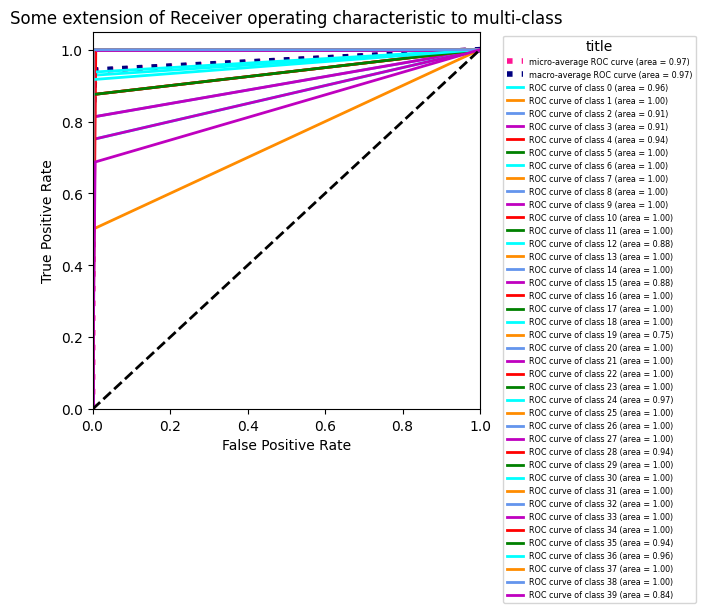

In [ ]:
from sklearn.preprocessing import label_binarize
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

class_array = []
i = 0
while i < n_classes:
  class_array.append(i)
  i += 1

i = 0

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(label_binarize(y_test,class_array )[:, i], label_binarize(pred_clf,class_array)[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(label_binarize(y_test,class_array ).ravel(), label_binarize(pred_clf,class_array).ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])
lw = 2
# Plot all ROC curves
plt.figure(figsize=(5, 5), dpi=100)

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'm', 'r','green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right", )

from matplotlib.font_manager import FontProperties

fontP = FontProperties()
fontP.set_size('xx-small')

plt.legend( title='title', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)

plt.show()



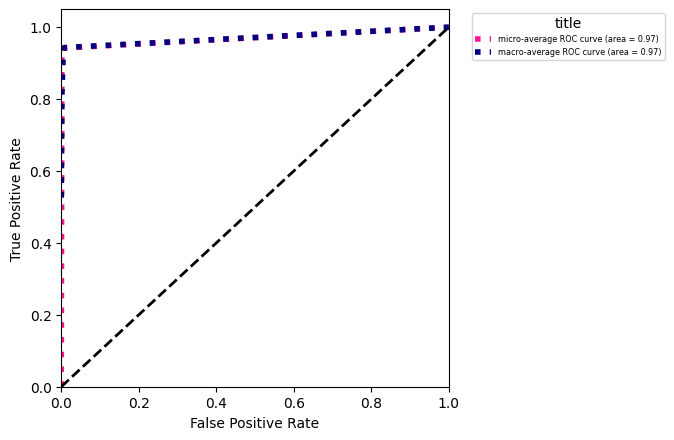

In [ ]:
# Plot macro-micro ROC curves
plt.figure(figsize=(5, 5), dpi=100)

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right", )

from matplotlib.font_manager import FontProperties

fontP = FontProperties()
fontP.set_size('xx-small')

plt.legend( title='title', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)

plt.show()

In [ ]:
def getPred(model, img):
  featureVector = cnnModel.predict(x_test[arn].reshape(1,224,224,3))
  
  return model.predict(pca.transform(featureVector.reshape(featureVector.shape[0], -1)))

## Seleccionamos un elemento aleatorio de test

import random
arn = random.randint(0, len(x_test))

print ("Prediction for x_test["+str(arn)+"]  from  "+ str(y_test[arn]) )

pred = getPred(clf, x_test[arn]) 
print("Prediction from RF: " + str(pred))

Prediction for x_test[54]  from  13
Prediction from RF: [13]


[20]


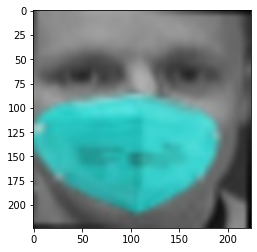

In [ ]:
# Probamos una imagen en concreto
pathToImg = "./drive/MyDrive/TFG/Datasets/ORL_DB_Masked/00021/201.jpg"

def getClfPred(classifier, img_path):
  img = cv2.imread(img_path)
  img = cv2.resize(img, (imgL, imgL))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  kernel = np.ones((5,5),np.float32)/25
  img = cv2.filter2D(img,-1,kernel)
  plt.imshow(img)

  featureVector = cnnModel.predict(img.reshape(1, 224, 224, 3))
  
  return classifier.predict(pca.transform(featureVector.reshape(featureVector.shape[0], -1)))
clfpred = getClfPred(clf, pathToImg)

print(clfpred)